# BDD100K Dataset Exploration

This notebook provides a comprehensive analysis of the BDD100K dataset for road object detection.

## Table of Contents
1. [Setup & Imports](#1-setup--imports)
2. [Dataset Overview](#2-dataset-overview)
3. [Label Format Analysis](#3-label-format-analysis)
4. [Class Distribution](#4-class-distribution)
5. [Attribute Analysis](#5-attribute-analysis)
6. [Bounding Box Analysis](#6-bounding-box-analysis)
7. [Objects Per Image](#7-objects-per-image)
8. [Traffic Light Color Distribution](#8-traffic-light-color-distribution)
9. [Image Visualization with Annotations](#9-image-visualization-with-annotations)
10. [Statistics Summary](#10-statistics-summary)
11. [Insights & Recommendations](#11-insights--recommendations)

## 1. Setup & Imports

In [25]:
# Standard library imports
import json
import os
from pathlib import Path
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries imported successfully!")

Libraries imported successfully!


In [26]:
# Define dataset paths
BASE_DIR = Path(r"c:\My Projects\road-object-detection")
IMAGES_DIR = BASE_DIR / "bdd100k_images_100k"
LABELS_DIR = BASE_DIR / "bdd100k_labels"

# Split directories
SPLITS = ['train', 'val', 'test']

# Create path dictionary
image_paths = {split: IMAGES_DIR / split for split in SPLITS}
label_paths = {split: LABELS_DIR / split for split in SPLITS}

print("Dataset paths configured:")
print(f"Base directory: {BASE_DIR}")
print(f"Images directory: {IMAGES_DIR}")
print(f"Labels directory: {LABELS_DIR}")

Dataset paths configured:
Base directory: c:\My Projects\road-object-detection
Images directory: c:\My Projects\road-object-detection\bdd100k_images_100k
Labels directory: c:\My Projects\road-object-detection\bdd100k_labels


## 2. Dataset Overview

In [27]:
# Count images and labels in each split
dataset_info = []

for split in SPLITS:
    img_dir = image_paths[split]
    lbl_dir = label_paths[split]
    
    # Count files
    num_images = len(list(img_dir.glob("*.jpg"))) if img_dir.exists() else 0
    num_labels = len(list(lbl_dir.glob("*.json"))) if lbl_dir.exists() else 0
    
    dataset_info.append({
        'Split': split,
        'Images': num_images,
        'Labels': num_labels,
        'Match': num_images == num_labels
    })

# Create summary DataFrame
overview_df = pd.DataFrame(dataset_info)

# Add totals
total_row = {
    'Split': 'TOTAL',
    'Images': overview_df['Images'].sum(),
    'Labels': overview_df['Labels'].sum(),
    'Match': overview_df['Match'].all()
}
overview_df = pd.concat([overview_df, pd.DataFrame([total_row])], ignore_index=True)

# Display
print("=" * 50)
print("BDD100K DATASET OVERVIEW")
print("=" * 50)
overview_df

BDD100K DATASET OVERVIEW


Split  Images  Labels  Match
0  train   70000   70000   True
1    val   10000   10000   True
2   test   20000   20000   True
3  TOTAL  100000  100000   True

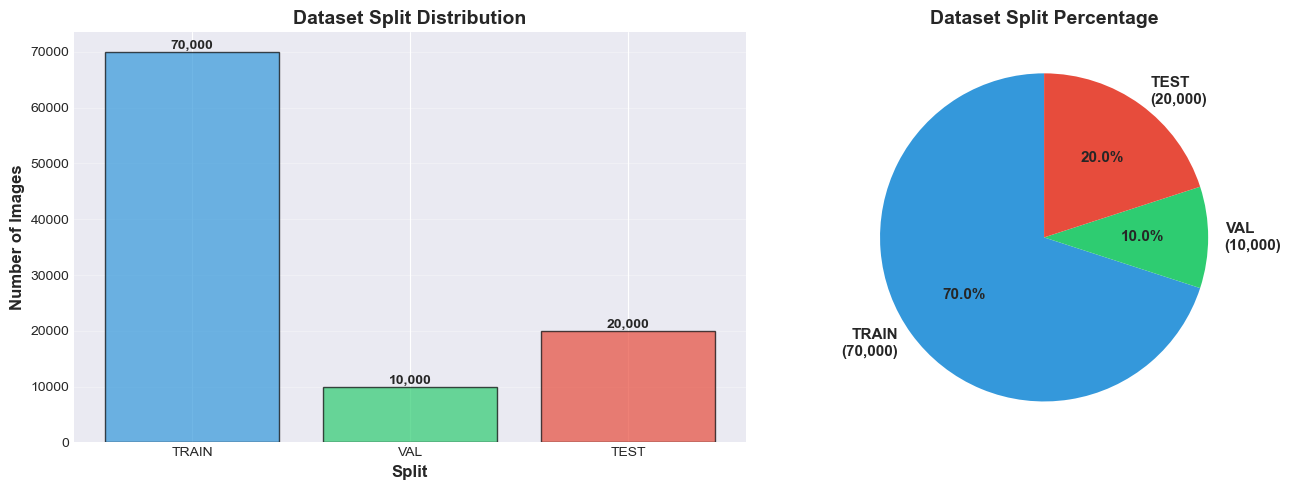

In [28]:
# Visualize dataset split distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
colors = ['#3498db', '#2ecc71', '#e74c3c']
bars = axes[0].bar(overview_df[overview_df['Split'] != 'TOTAL']['Split'].str.upper(), 
                     overview_df[overview_df['Split'] != 'TOTAL']['Images'], 
                     color=colors, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Split', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Images', fontsize=12, fontweight='bold')
axes[0].set_title('Dataset Split Distribution', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom', fontweight='bold')

# Pie chart
sizes = overview_df[overview_df['Split'] != 'TOTAL']['Images'].values
labels = [f'{s}\n({int(c):,})' for s, c in zip(overview_df[overview_df['Split'] != 'TOTAL']['Split'].str.upper(), sizes)]
axes[1].pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, 
            startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Dataset Split Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 2.1 Image Resolution Analysis

Checking the resolution of images across all splits.

In [79]:
# Check image resolutions across all splits
from PIL import Image

def check_image_resolutions(split, sample_size=1000):
    """
    Check resolutions of images in a split.
    Samples 'sample_size' images for efficiency.
    """
    img_dir = image_paths[split]
    image_files = list(img_dir.glob("*.jpg"))
    
    # Sample images for efficiency (check all if dataset is small)
    if len(image_files) > sample_size:
        sample_files = np.random.choice(image_files, sample_size, replace=False)
    else:
        sample_files = image_files
    
    resolutions = []
    for img_path in tqdm(sample_files, desc=f"Checking {split} resolutions"):
        try:
            with Image.open(img_path) as img:
                resolutions.append(img.size)
        except Exception as e:
            print(f"Error reading {img_path}: {e}")
    
    return resolutions

# Check resolutions for all splits
all_resolutions = {}
for split in SPLITS:
    all_resolutions[split] = check_image_resolutions(split, sample_size=2000)

# Analyze results
print("=" * 70)
print("IMAGE RESOLUTION ANALYSIS")
print("=" * 70)

unique_resolutions = {}
for split, resolutions in all_resolutions.items():
    unique_res = set(resolutions)
    unique_resolutions[split] = unique_res
    print(f"\n{split.upper()} split:")
    print(f"  Images sampled: {len(resolutions):,}")
    print(f"  Unique resolutions found: {len(unique_res)}")
    if len(unique_res) <= 5:
        for res in sorted(unique_res):
            count = resolutions.count(res)
            pct = count / len(resolutions) * 100
            print(f"    {res[0]}x{res[1]}: {count:,} ({pct:.1f}%)")
    else:
        # Show top 5 most common
        from collections import Counter
        res_counts = Counter(resolutions)
        print(f"  Top 5 most common resolutions:")
        for res, count in res_counts.most_common(5):
            pct = count / len(resolutions) * 100
            print(f"    {res[0]}x{res[1]}: {count:,} ({pct:.1f}%)")

# Check if all splits have consistent resolution
all_unique = set()
for res_list in all_resolutions.values():
    all_unique.update(res_list)

print(f"\n{'=' * 70}")
print(f"OVERALL SUMMARY")
print(f"{'=' * 70}")
print(f"Total unique resolutions across all splits: {len(all_unique)}")

if len(all_unique) == 1:
    res = list(all_unique)[0]
    print(f"✓ All images have consistent resolution: {res[0]}x{res[1]}")
else:
    print(f"⚠ Images have varying resolutions!")
    from collections import Counter
    all_res_list = []
    for res_list in all_resolutions.values():
        all_res_list.extend(res_list)
    overall_counts = Counter(all_res_list)
    print(f"\nOverall resolution distribution:")
    for res, count in overall_counts.most_common(10):
        pct = count / len(all_res_list) * 100
        print(f"  {res[0]}x{res[1]}: {count:,} ({pct:.1f}%)")

Checking test resolutions: 100%|██████████| 2000/2000 [00:01<00:00, 1310.91it/s]

IMAGE RESOLUTION ANALYSIS

TRAIN split:
  Images sampled: 2,000
  Unique resolutions found: 1
    1280x720: 2,000 (100.0%)

VAL split:
  Images sampled: 2,000
  Unique resolutions found: 1
    1280x720: 2,000 (100.0%)

TEST split:
  Images sampled: 2,000
  Unique resolutions found: 1
    1280x720: 2,000 (100.0%)

OVERALL SUMMARY
Total unique resolutions across all splits: 1
✓ All images have consistent resolution: 1280x720


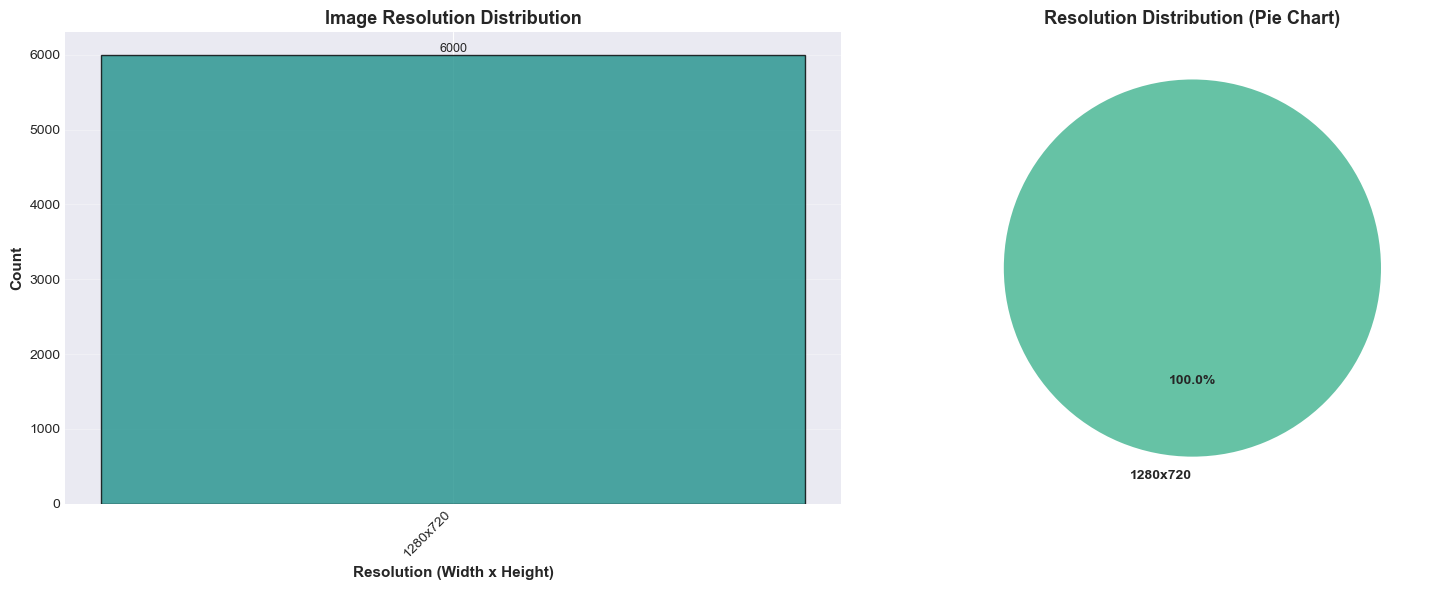

In [80]:
# Visualize resolution distribution
from collections import Counter

# Combine all resolutions
all_res_list = []
for split, resolutions in all_resolutions.items():
    all_res_list.extend(resolutions)

overall_counts = Counter(all_res_list)

# Sort by resolution
sorted_res = sorted(overall_counts.items(), key=lambda x: x[0][0] * x[0][1], reverse=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of resolutions
if len(sorted_res) <= 10:
    res_labels = [f"{res[0]}x{res[1]}" for res, _ in sorted_res]
    counts = [count for _, count in sorted_res]
    colors = sns.color_palette("viridis", len(sorted_res))
    
    bars = axes[0].bar(range(len(sorted_res)), counts, color=colors, edgecolor='black', alpha=0.8)
    axes[0].set_xticks(range(len(sorted_res)))
    axes[0].set_xticklabels(res_labels, rotation=45, ha='right')
    axes[0].set_xlabel('Resolution (Width x Height)', fontsize=11, fontweight='bold')
    axes[0].set_ylabel('Count', fontsize=11, fontweight='bold')
    axes[0].set_title('Image Resolution Distribution', fontsize=13, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom', fontsize=9)
else:
    # Show top 10
    top_10 = sorted_res[:10]
    res_labels = [f"{res[0]}x{res[1]}" for res, _ in top_10]
    counts = [count for _, count in top_10]
    colors = sns.color_palette("viridis", 10)
    
    bars = axes[0].bar(range(len(top_10)), counts, color=colors, edgecolor='black', alpha=0.8)
    axes[0].set_xticks(range(len(top_10)))
    axes[0].set_xticklabels(res_labels, rotation=45, ha='right')
    axes[0].set_xlabel('Resolution (Width x Height)', fontsize=11, fontweight='bold')
    axes[0].set_ylabel('Count', fontsize=11, fontweight='bold')
    axes[0].set_title('Top 10 Image Resolutions', fontsize=13, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom', fontsize=9)

# Pie chart - top resolutions
top_n = min(5, len(sorted_res))
top_res = sorted_res[:top_n]
other_count = sum(count for _, count in sorted_res[top_n:])

pie_labels = [f"{res[0]}x{res[1]}" for res, _ in top_res]
pie_counts = [count for _, count in top_res]

if other_count > 0:
    pie_labels.append("Other")
    pie_counts.append(other_count)

colors_pie = sns.color_palette("Set2", len(pie_labels))
axes[1].pie(pie_counts, labels=pie_labels, autopct='%1.1f%%', 
            colors=colors_pie, startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
axes[1].set_title('Resolution Distribution (Pie Chart)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Label Format Analysis

In [29]:
# Load a sample label file to understand the structure
sample_label_path = list(label_paths['train'].glob("*.json"))[0]

with open(sample_label_path, 'r') as f:
    sample_label = json.load(f)

print("=" * 50)
print("SAMPLE LABEL FILE STRUCTURE")
print("=" * 50)
print(f"\nFile: {sample_label_path.name}")
print("\n" + "-" * 50)

# Pretty print the JSON structure
print(json.dumps(sample_label, indent=2))

print("\n" + "=" * 50)
print("LABEL SCHEMA EXPLANATION")
print("=" * 50)
print("""
Top-level fields:
  - name: Image identifier (matches filename)
  - frames: Array containing frame information
    - timestamp: Frame timestamp in milliseconds
    - objects: Array of detected objects
      - category: Object class (car, person, traffic light, etc.)
      - id: Unique object identifier
      - attributes: Object-specific attributes
        - occluded: Whether object is partially hidden
        - truncated: Whether object is cut off at image boundary
        - trafficLightColor: Color for traffic lights (green/red/yellow/none)
      - box2d: 2D bounding box coordinates
        - x1, y1: Top-left corner
        - x2, y2: Bottom-right corner
      - poly2d: Polygon coordinates for segmentation/lane detection
  - attributes: Image-level attributes
    - weather: Weather condition (clear, rainy, snowy, overcast, foggy, undefined)
    - scene: Scene type (city street, highway, residential, parking lot, tunnel, gas stations)
    - timeofday: Time of day (daytime, night, dawn/dusk)
""")

SAMPLE LABEL FILE STRUCTURE

File: 0000f77c-6257be58.json

--------------------------------------------------
{
  "name": "0000f77c-6257be58",
  "frames": [
    {
      "timestamp": 10000,
      "objects": [
        {
          "category": "traffic light",
          "id": 0,
          "attributes": {
            "occluded": false,
            "truncated": false,
            "trafficLightColor": "green"
          },
          "box2d": {
            "x1": 1125.902264,
            "y1": 133.184488,
            "x2": 1156.978645,
            "y2": 210.875445
          }
        },
        {
          "category": "traffic light",
          "id": 1,
          "attributes": {
            "occluded": false,
            "truncated": false,
            "trafficLightColor": "green"
          },
          "box2d": {
            "x1": 1156.978645,
            "y1": 136.637417,
            "x2": 1191.50796,
            "y2": 210.875443
          }
        },
        {
          "category": "traffic 

## 4. Class Distribution

Analyzing the distribution of object categories across the dataset. This section processes all label files to count category occurrences.

In [30]:
# Function to parse label files and extract categories
def parse_labels(split, max_files=None):
    """
    Parse all label files for a given split.
    Set max_files to limit processing for quick testing.
    """
    lbl_dir = label_paths[split]
    label_files = list(lbl_dir.glob("*.json"))
    
    if max_files:
        label_files = label_files[:max_files]
    
    data = {
        'categories': [],
        'weather': [],
        'scene': [],
        'timeofday': [],
        'traffic_light_colors': [],
        'boxes': [],  # (x1, y1, x2, y2, category)
        'objects_per_image': [],
        'occluded': [],
        'truncated': []
    }
    
    for label_file in tqdm(label_files, desc=f"Processing {split}"):
        try:
            with open(label_file, 'r') as f:
                label_data = json.load(f)
            
            # Image-level attributes
            if 'attributes' in label_data:
                data['weather'].append(label_data['attributes'].get('weather', 'undefined'))
                data['scene'].append(label_data['attributes'].get('scene', 'undefined'))
                data['timeofday'].append(label_data['attributes'].get('timeofday', 'undefined'))
            
            # Process objects
            objects_in_frame = 0
            if 'frames' in label_data and len(label_data['frames']) > 0:
                for obj in label_data['frames'][0].get('objects', []):
                    category = obj.get('category', 'unknown')
                    data['categories'].append(category)
                    objects_in_frame += 1
                    
                    # Store bounding box info
                    if 'box2d' in obj:
                        box = obj['box2d']
                        data['boxes'].append({
                            'x1': box['x1'],
                            'y1': box['y1'],
                            'x2': box['x2'],
                            'y2': box['y2'],
                            'category': category
                        })
                    
                    # Object attributes
                    attrs = obj.get('attributes', {})
                    data['occluded'].append(attrs.get('occluded', False))
                    data['truncated'].append(attrs.get('truncated', False))
                    
                    # Traffic light colors
                    if category == 'traffic light':
                        tl_color = attrs.get('trafficLightColor', 'none')
                        data['traffic_light_colors'].append(tl_color)
            
            data['objects_per_image'].append(objects_in_frame)
            
        except Exception as e:
            print(f"Error processing {label_file}: {e}")
    
    return data

print("Label parsing function defined.")

Label parsing function defined.


In [31]:
# Parse labels for all splits (this may take a few minutes)
# Adjust max_files if you want to process a subset for faster testing
MAX_FILES = None  # Set to None to process all files, or a number to limit

all_data = {
    'train': parse_labels('train', max_files=MAX_FILES),
    'val': parse_labels('val', max_files=MAX_FILES),
    'test': parse_labels('test', max_files=MAX_FILES)
}

print("\nLabel parsing completed!")

Processing test: 100%|██████████| 20000/20000 [00:10<00:00, 1891.61it/s]


Label parsing completed!


In [32]:
# Combine all splits for overall analysis
all_categories = []
for split_data in all_data.values():
    all_categories.extend(split_data['categories'])

# Count categories
category_counts = Counter(all_categories)

# Create DataFrame
category_df = pd.DataFrame({
    'Category': list(category_counts.keys()),
    'Count': list(category_counts.values())
})
category_df = category_df.sort_values('Count', ascending=False).reset_index(drop=True)
category_df['Percentage'] = (category_df['Count'] / category_df['Count'].sum() * 100).round(2)

print("=" * 60)
print("OBJECT CATEGORY DISTRIBUTION")
print("=" * 60)
print(f"\nTotal annotated objects: {category_df['Count'].sum():,}")
print(f"Number of unique categories: {len(category_df)}")
print("\n" + "-" * 60)
category_df.head(20)

OBJECT CATEGORY DISTRIBUTION

Total annotated objects: 2,777,733
Number of unique categories: 21

------------------------------------------------------------


Category    Count  Percentage
0                  car  1021811       36.79
1    lane/single white   353334       12.72
2         traffic sign   343882       12.38
3        traffic light   266032        9.58
4       lane/road curb   157406        5.67
5       lane/crosswalk   154228        5.55
6               person   129350        4.66
7        area/drivable    91625        3.30
8     area/alternative    88379        3.18
9   lane/double yellow    53449        1.92
10               truck    42963        1.55
11  lane/single yellow    28962        1.04
12                 bus    16502        0.59
13                bike    10232        0.37
14   lane/double white     8206        0.30
15               rider     6465        0.23
16               motor     4295        0.15
17   lane/single other      394        0.01
18               train      179        0.01
19   lane/double other       37        0.00

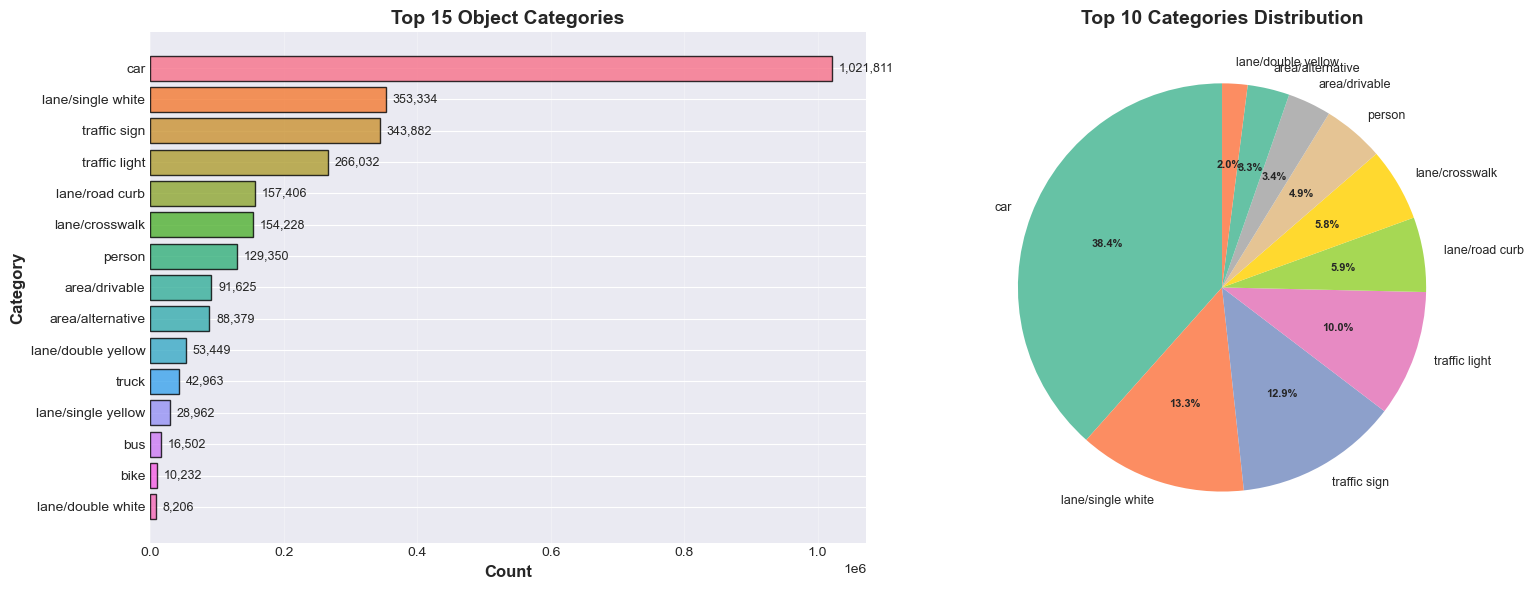

In [33]:
# Visualize category distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot - top categories
top_n = 15
top_categories = category_df.head(top_n)

bars = axes[0].barh(top_categories['Category'], top_categories['Count'], 
                     color=sns.color_palette("husl", top_n), edgecolor='black', alpha=0.8)
axes[0].set_xlabel('Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Category', fontsize=12, fontweight='bold')
axes[0].set_title(f'Top {top_n} Object Categories', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Add count labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    axes[0].text(width + max(top_categories['Count'])*0.01, bar.get_y() + bar.get_height()/2,
                f'{int(width):,}', ha='left', va='center', fontsize=9)

# Pie chart - top 10 categories
top_10 = category_df.head(10)
colors_pie = sns.color_palette("Set2", 10)
wedges, texts, autotexts = axes[1].pie(top_10['Count'], labels=top_10['Category'], 
                                         autopct='%1.1f%%', colors=colors_pie, 
                                         startangle=90, textprops={'fontsize': 9})
for autotext in autotexts:
    autotext.set_fontsize(8)
    autotext.set_fontweight('bold')
axes[1].set_title('Top 10 Categories Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [34]:
# Detection-relevant categories (for object detection)
detection_categories = ['car', 'truck', 'bus', 'person', 'rider', 'bike', 'motor', 
                        'traffic light', 'traffic sign', 'train', 'trailer']

detection_df = category_df[category_df['Category'].isin(detection_categories)].copy()
detection_df = detection_df.sort_values('Count', ascending=False).reset_index(drop=True)

print("=" * 60)
print("DETECTION-RELEVANT CATEGORIES (for YOLO11 Training)")
print("=" * 60)
detection_df

DETECTION-RELEVANT CATEGORIES (for YOLO11 Training)


Category    Count  Percentage
0            car  1021811       36.79
1   traffic sign   343882       12.38
2  traffic light   266032        9.58
3         person   129350        4.66
4          truck    42963        1.55
5            bus    16502        0.59
6           bike    10232        0.37
7          rider     6465        0.23
8          motor     4295        0.15
9          train      179        0.01

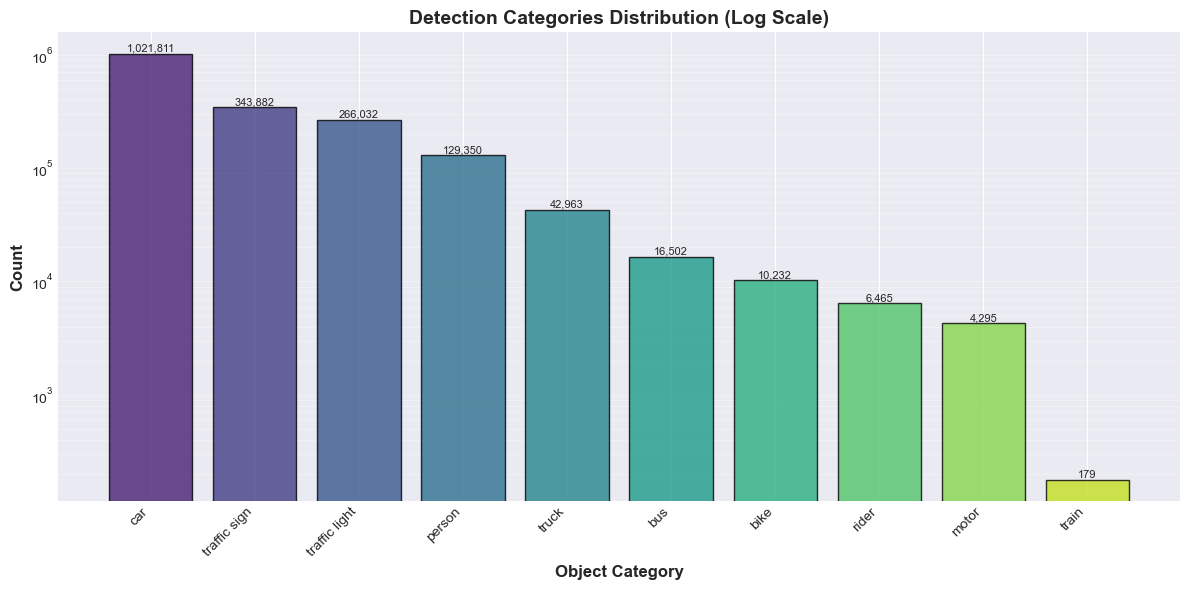


Note: Log scale is used to better visualize the class imbalance.
Consider using class weights or oversampling for rare categories during YOLO11 training.


In [35]:
# Class imbalance visualization
fig, ax = plt.subplots(figsize=(12, 6))

x_pos = np.arange(len(detection_df))
bars = ax.bar(x_pos, detection_df['Count'], 
              color=sns.color_palette("viridis", len(detection_df)), 
              edgecolor='black', alpha=0.8)

ax.set_xlabel('Object Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Detection Categories Distribution (Log Scale)', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(detection_df['Category'], rotation=45, ha='right')
ax.set_yscale('log')
ax.grid(axis='y', alpha=0.3, which='both')

# Add count labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(detection_df["Count"].iloc[i]):,}', 
            ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("\nNote: Log scale is used to better visualize the class imbalance.")
print("Consider using class weights or oversampling for rare categories during YOLO11 training.")

## 5. Attribute Analysis

Analyzing image-level attributes: weather, scene, and time of day.

In [36]:
# Combine attributes from all splits
all_weather = []
all_scene = []
all_timeofday = []

for split_data in all_data.values():
    all_weather.extend(split_data['weather'])
    all_scene.extend(split_data['scene'])
    all_timeofday.extend(split_data['timeofday'])

# Count attributes
weather_counts = Counter(all_weather)
scene_counts = Counter(all_scene)
timeofday_counts = Counter(all_timeofday)

print("=" * 60)
print("IMAGE-LEVEL ATTRIBUTE DISTRIBUTIONS")
print("=" * 60)

# Weather
print("\n--- WEATHER CONDITIONS ---")
for weather, count in weather_counts.most_common():
    pct = count / len(all_weather) * 100
    print(f"  {weather:20s}: {count:>8,} ({pct:>5.2f}%)")

print("\n--- SCENE TYPES ---")
for scene, count in scene_counts.most_common():
    pct = count / len(all_scene) * 100
    print(f"  {scene:20s}: {count:>8,} ({pct:>5.2f}%)")

print("\n--- TIME OF DAY ---")
for tod, count in timeofday_counts.most_common():
    pct = count / len(all_timeofday) * 100
    print(f"  {tod:20s}: {count:>8,} ({pct:>5.2f}%)")

IMAGE-LEVEL ATTRIBUTE DISTRIBUTIONS

--- WEATHER CONDITIONS ---
  clear               :   53,514 (53.51%)
  overcast            :   12,591 (12.59%)
  undefined           :   11,631 (11.63%)
  snowy               :    7,891 ( 7.89%)
  rainy               :    7,127 ( 7.13%)
  partly cloudy       :    7,065 ( 7.07%)
  foggy               :      181 ( 0.18%)

--- SCENE TYPES ---
  city street         :   61,981 (61.98%)
  highway             :   24,982 (24.98%)
  residential         :   11,740 (11.74%)
  parking lot         :      535 ( 0.53%)
  undefined           :      517 ( 0.52%)
  tunnel              :      205 ( 0.21%)
  gas stations        :       40 ( 0.04%)

--- TIME OF DAY ---
  daytime             :   52,504 (52.50%)
  night               :   39,993 (39.99%)
  dawn/dusk           :    7,287 ( 7.29%)
  undefined           :      216 ( 0.22%)


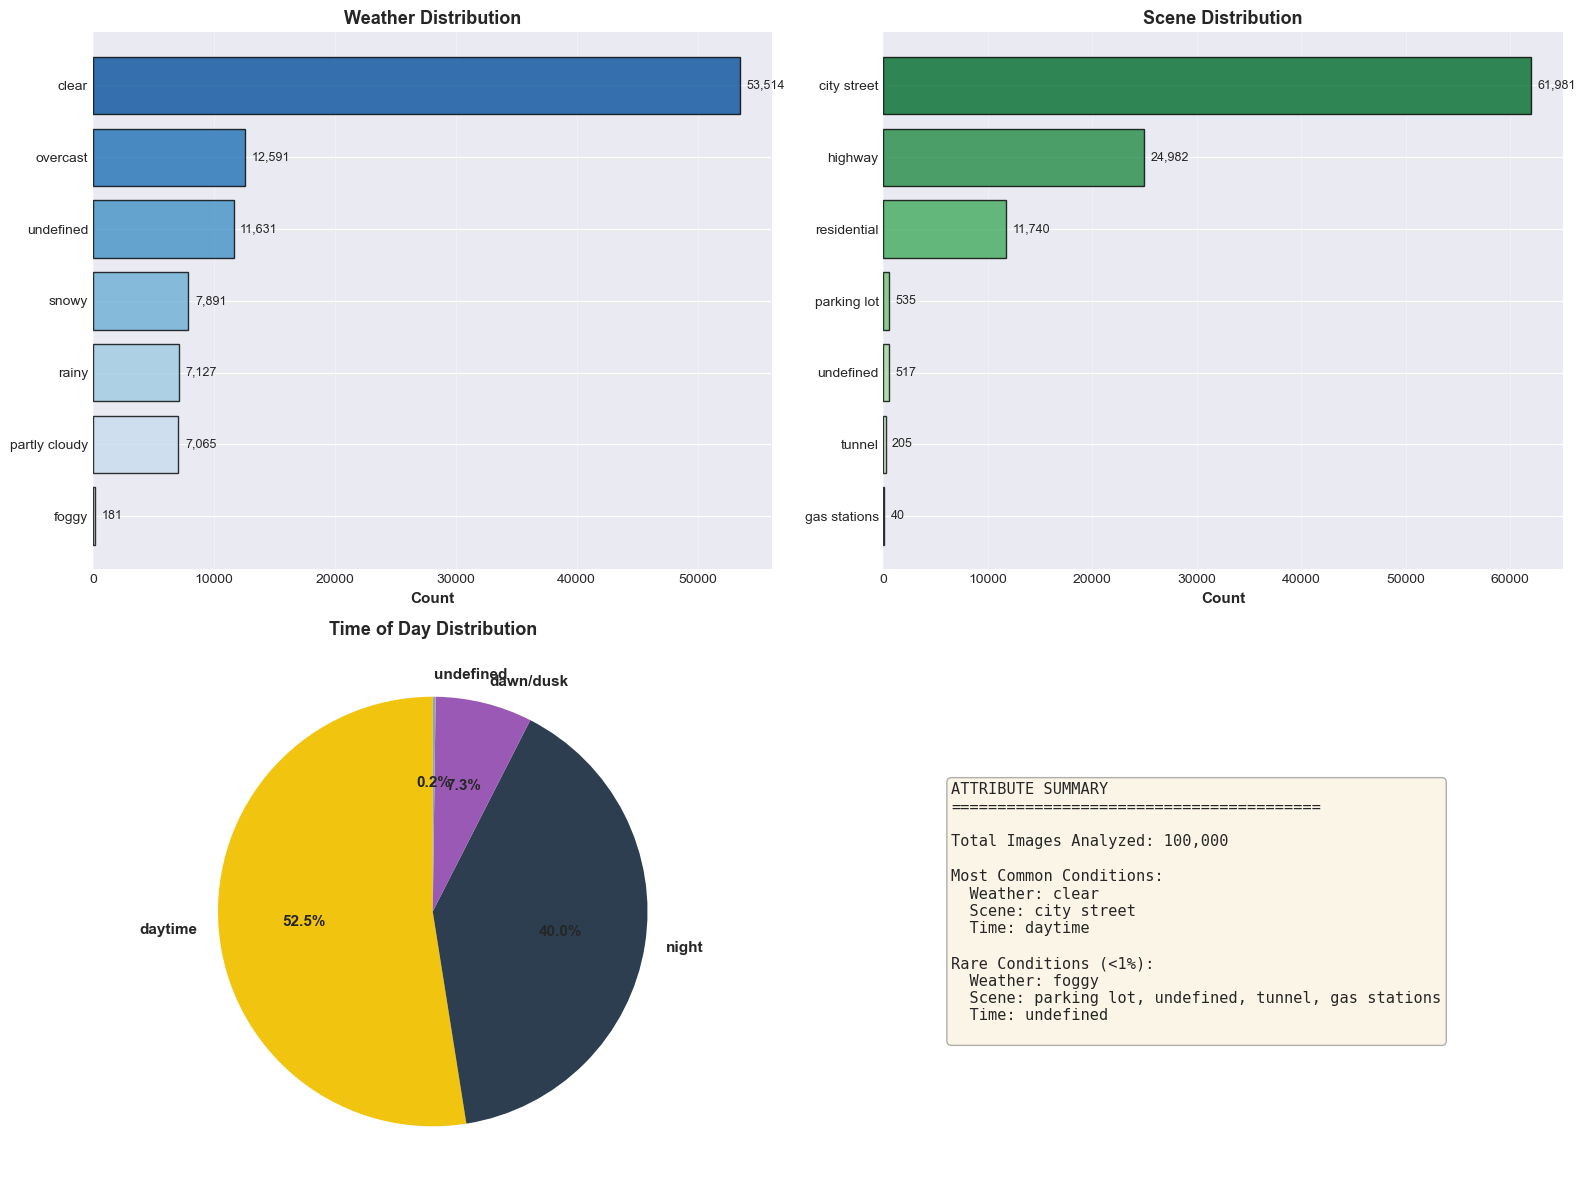

In [37]:
# Visualize attributes
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Weather distribution
weather_df = pd.DataFrame(list(weather_counts.items()), columns=['Weather', 'Count'])
weather_df = weather_df.sort_values('Count', ascending=False)
colors_weather = sns.color_palette("Blues_r", len(weather_df))
bars1 = axes[0, 0].barh(weather_df['Weather'], weather_df['Count'], color=colors_weather, edgecolor='black', alpha=0.8)
axes[0, 0].set_xlabel('Count', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Weather Distribution', fontsize=13, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)
for bar in bars1:
    width = bar.get_width()
    axes[0, 0].text(width + max(weather_df['Count'])*0.01, bar.get_y() + bar.get_height()/2,
                f'{int(width):,}', ha='left', va='center', fontsize=9)

# Scene distribution
scene_df = pd.DataFrame(list(scene_counts.items()), columns=['Scene', 'Count'])
scene_df = scene_df.sort_values('Count', ascending=False)
colors_scene = sns.color_palette("Greens_r", len(scene_df))
bars2 = axes[0, 1].barh(scene_df['Scene'], scene_df['Count'], color=colors_scene, edgecolor='black', alpha=0.8)
axes[0, 1].set_xlabel('Count', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Scene Distribution', fontsize=13, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)
for bar in bars2:
    width = bar.get_width()
    axes[0, 1].text(width + max(scene_df['Count'])*0.01, bar.get_y() + bar.get_height()/2,
                f'{int(width):,}', ha='left', va='center', fontsize=9)

# Time of day distribution
timeofday_df = pd.DataFrame(list(timeofday_counts.items()), columns=['Time', 'Count'])
timeofday_df = timeofday_df.sort_values('Count', ascending=False)
colors_time = ['#f1c40f', '#2c3e50', '#9b59b6', '#95a5a6']  # Day, Night, Dawn/Dusk, Undefined
wedges, texts, autotexts = axes[1, 0].pie(timeofday_df['Count'], labels=timeofday_df['Time'], 
                                         autopct='%1.1f%%', colors=colors_time[:len(timeofday_df)], 
                                         startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1, 0].set_title('Time of Day Distribution', fontsize=13, fontweight='bold')

# Combined attribute summary table
axes[1, 1].axis('off')
summary_text = "ATTRIBUTE SUMMARY\n" + "="*40 + "\n\n"
summary_text += f"Total Images Analyzed: {len(all_weather):,}\n\n"
summary_text += "Most Common Conditions:\n"
summary_text += f"  Weather: {weather_counts.most_common(1)[0][0]}\n"
summary_text += f"  Scene: {scene_counts.most_common(1)[0][0]}\n"
summary_text += f"  Time: {timeofday_counts.most_common(1)[0][0]}\n\n"
summary_text += "Rare Conditions (<1%):\n"
for attr, counts in [('Weather', weather_counts), ('Scene', scene_counts), ('Time', timeofday_counts)]:
    rare = [k for k, v in counts.items() if v/len(all_weather)*100 < 1]
    if rare:
        summary_text += f"  {attr}: {', '.join(rare)}\n"

axes[1, 1].text(0.1, 0.5, summary_text, transform=axes[1, 1].transAxes, 
               fontsize=11, verticalalignment='center', family='monospace',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

## 6. Bounding Box Analysis

Analyzing the size, position, and aspect ratios of bounding boxes.

In [38]:
# Combine boxes from all splits
all_boxes = []
for split_data in all_data.values():
    all_boxes.extend(split_data['boxes'])

# Convert to DataFrame
boxes_df = pd.DataFrame(all_boxes)

# Calculate box properties
boxes_df['width'] = boxes_df['x2'] - boxes_df['x1']
boxes_df['height'] = boxes_df['y2'] - boxes_df['y1']
boxes_df['area'] = boxes_df['width'] * boxes_df['height']
boxes_df['center_x'] = (boxes_df['x1'] + boxes_df['x2']) / 2
boxes_df['center_y'] = (boxes_df['y1'] + boxes_df['y2']) / 2

# Filter out invalid boxes (zero or negative dimensions)
boxes_df = boxes_df[(boxes_df['width'] > 0) & (boxes_df['height'] > 0)].copy()

# Calculate aspect ratio after filtering
boxes_df['aspect_ratio'] = boxes_df['width'] / boxes_df['height']

# Filter for detection categories only
detection_boxes_df = boxes_df[boxes_df['category'].isin(detection_categories)].copy()

# Also filter out infinite aspect ratios (extreme edge cases)
detection_boxes_df = detection_boxes_df[np.isfinite(detection_boxes_df['aspect_ratio'])].copy()

print("=" * 60)
print("BOUNDING BOX STATISTICS")
print("=" * 60)
print(f"\nTotal bounding boxes: {len(detection_boxes_df):,}")

# Display statistics
stats_columns = ['width', 'height', 'area', 'aspect_ratio']
stats_df = detection_boxes_df[stats_columns].describe()
print("\n" + "-" * 60)
print("DETECTION CATEGORIES - BOX STATISTICS")
print("-" * 60)
stats_df

BOUNDING BOX STATISTICS

Total bounding boxes: 1,841,157

------------------------------------------------------------
DETECTION CATEGORIES - BOX STATISTICS
------------------------------------------------------------


width        height          area  aspect_ratio
count  1.841157e+06  1.841157e+06  1.841157e+06  1.841157e+06
mean   5.655581e+01  4.984626e+01  6.754148e+03  1.217681e+00
std    7.551435e+01  6.154978e+01  2.274664e+04  1.021601e+00
min    1.054950e-01  1.654980e-01  6.224366e-01  1.510368e-03
25%    1.687499e+01  1.713855e+01  3.050175e+02  7.386363e-01
50%    2.874676e+01  2.909387e+01  8.173674e+02  1.100000e+00
75%    6.042161e+01  5.524063e+01  3.019948e+03  1.488372e+00
max    1.279356e+03  7.198896e+02  9.177098e+05  6.569629e+02

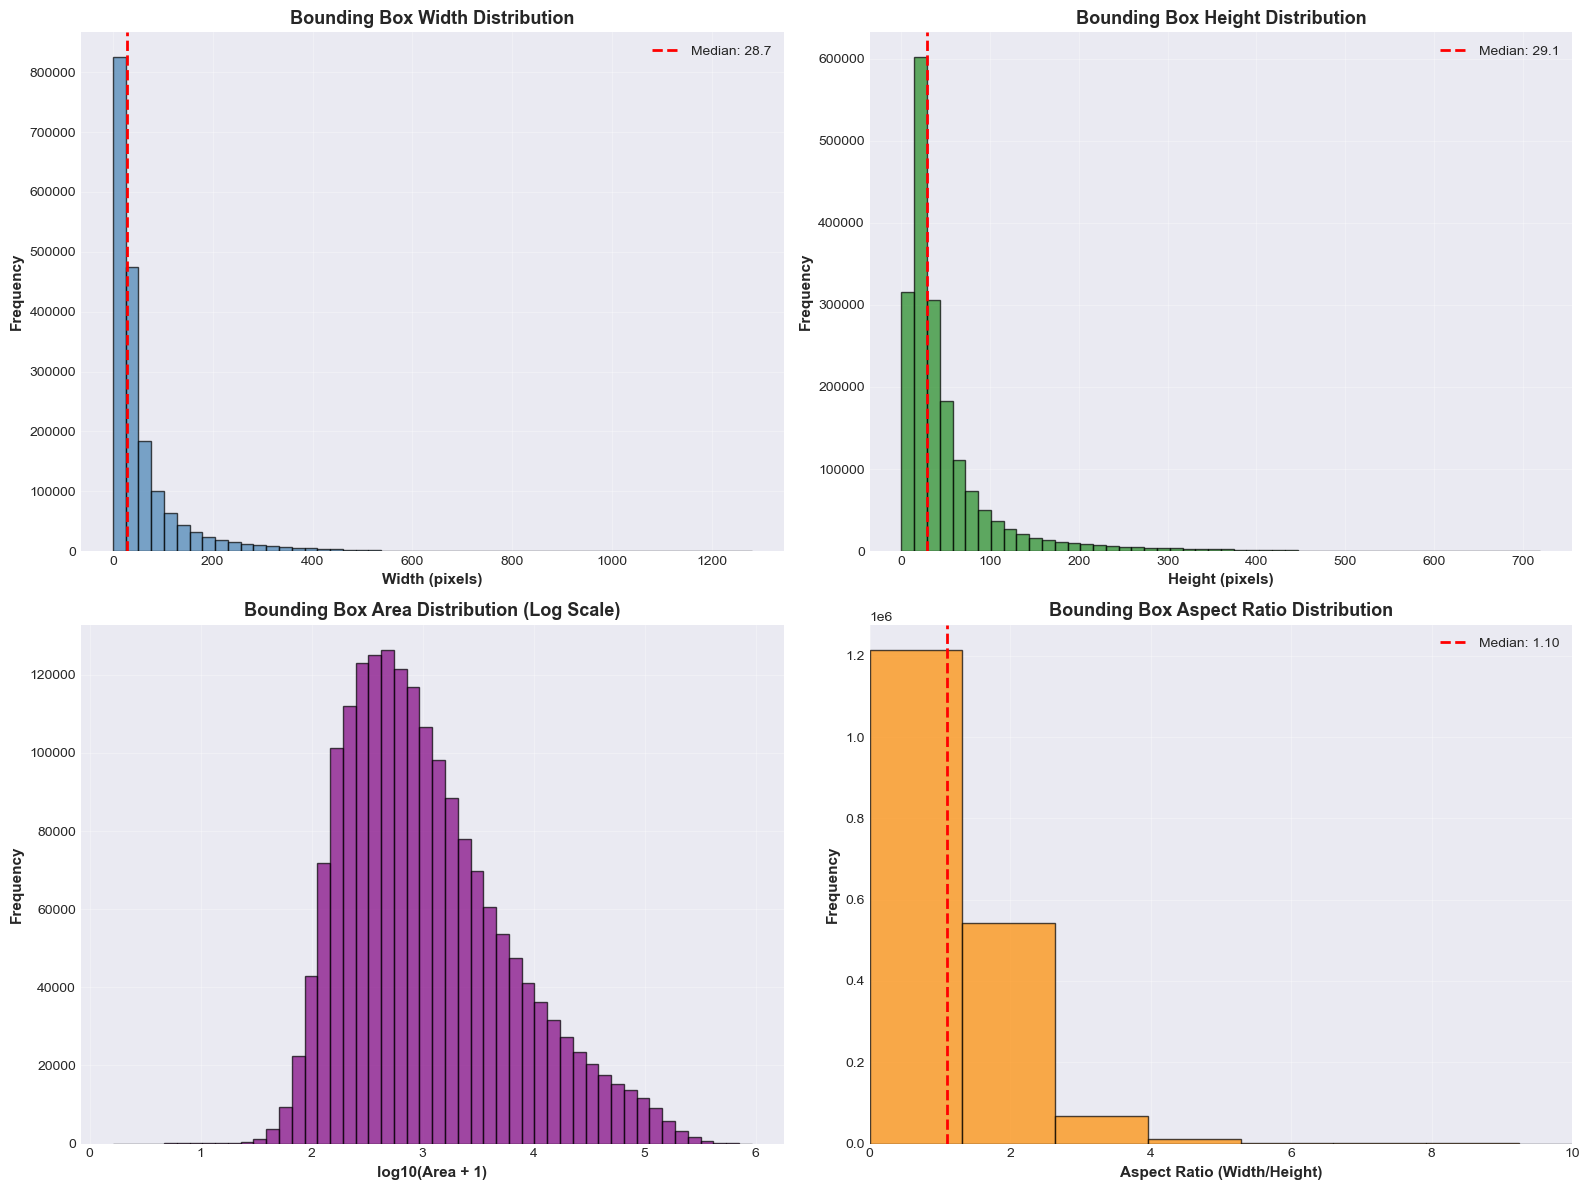

In [39]:
# Visualize box statistics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Filter for valid aspect ratios only
valid_aspect_ratios = detection_boxes_df['aspect_ratio'][
    np.isfinite(detection_boxes_df['aspect_ratio']) & 
    (detection_boxes_df['aspect_ratio'] < 100)  # Also filter extreme values
]

# Width distribution
axes[0, 0].hist(detection_boxes_df['width'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Width (pixels)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Bounding Box Width Distribution', fontsize=13, fontweight='bold')
axes[0, 0].axvline(detection_boxes_df['width'].median(), color='red', linestyle='--', linewidth=2, label=f"Median: {detection_boxes_df['width'].median():.1f}")
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Height distribution
axes[0, 1].hist(detection_boxes_df['height'], bins=50, color='forestgreen', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Height (pixels)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Bounding Box Height Distribution', fontsize=13, fontweight='bold')
axes[0, 1].axvline(detection_boxes_df['height'].median(), color='red', linestyle='--', linewidth=2, label=f"Median: {detection_boxes_df['height'].median():.1f}")
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Area distribution (log scale)
axes[1, 0].hist(np.log10(detection_boxes_df['area'] + 1), bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('log10(Area + 1)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Bounding Box Area Distribution (Log Scale)', fontsize=13, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Aspect ratio distribution - use filtered data
axes[1, 1].hist(valid_aspect_ratios, bins=50, color='darkorange', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Aspect Ratio (Width/Height)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Bounding Box Aspect Ratio Distribution', fontsize=13, fontweight='bold')
axes[1, 1].axvline(valid_aspect_ratios.median(), color='red', linestyle='--', linewidth=2, label=f"Median: {valid_aspect_ratios.median():.2f}")
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_xlim(0, 10)  # Limit for better visualization

plt.tight_layout()
plt.show()

In [40]:
# Box statistics by category
category_box_stats = detection_boxes_df.groupby('category')[['width', 'height', 'area', 'aspect_ratio']].agg(['mean', 'median', 'std'])
category_box_stats.columns = ['_'.join(col).strip() for col in category_box_stats.columns.values]

print("=" * 80)
print("BOUNDING BOX STATISTICS BY CATEGORY")
print("=" * 80)
category_box_stats

BOUNDING BOX STATISTICS BY CATEGORY


width_mean  width_median   width_std  height_mean  \
category                                                           
bike            60.126116     47.249967   47.838820    66.801748   
bus            144.466769     91.124938  142.150971   126.123414   
car             74.514783     41.329145   86.281948    57.954730   
motor           67.422292     48.937466   62.025206    68.509478   
person          27.665530     21.211819   23.660416    66.645748   
rider           43.051952     30.317591   39.369762    81.379262   
traffic light   15.884467     13.479208   10.143872    25.302833   
traffic sign    32.359683     23.963038   29.661882    25.263128   
train          280.108622    155.969254  328.800833    85.458534   
truck          127.292966     82.372940  123.758628   115.058684   

               height_median  height_std     area_mean  area_median  \
category                                                              
bike               52.167321   49.278778   5819.167844  2444.970494   
bus                69.187452  145.082281  35170.802219  6181.143299   
car                33.781969   66.426410   9396.506958  1377.809110   
motor              51.350989   58.016726   7559.074257  2493.869955   
person             52.103500   53.699557   2929.238939  1082.107927   
rider              58.644253   73.527126   6142.247734  1751.501419   
traffic light      20.193916   16.187626    506.869778   262.893229   
traffic sign       18.805321   20.697069   1203.034746   445.850687   
train              42.484767  105.943917  39294.665426  7102.333481   
truck              67.784211  127.022444  27721.875109  5590.992213   

                   area_std  aspect_ratio_mean  aspect_ratio_median  \
category                                                              
bike           10456.354672           0.958926             0.843750   
bus            72488.275248           1.424550             1.166855   
car            24959.774804           1.347187             1.250000   
motor          15944.138711           1.024451             0.907922   
person          7498.393369           0.465117             0.410714   
rider          13831.715980           0.585380             0.538462   
traffic light   1635.237889           0.714174             0.611111   
traffic sign    4010.461709           1.506368             1.170732   
train          71773.948361           4.095272             1.826923   
truck          58954.918664           1.294574             1.117647   

               aspect_ratio_std  
category                         
bike                   0.508331  
bus                    0.864886  
car                    0.913491  
motor                  0.449599  
person                 1.852898  
rider                  0.310521  
traffic light          0.449972  
traffic sign           0.990719  
train                  4.884091  
truck                  0.697353

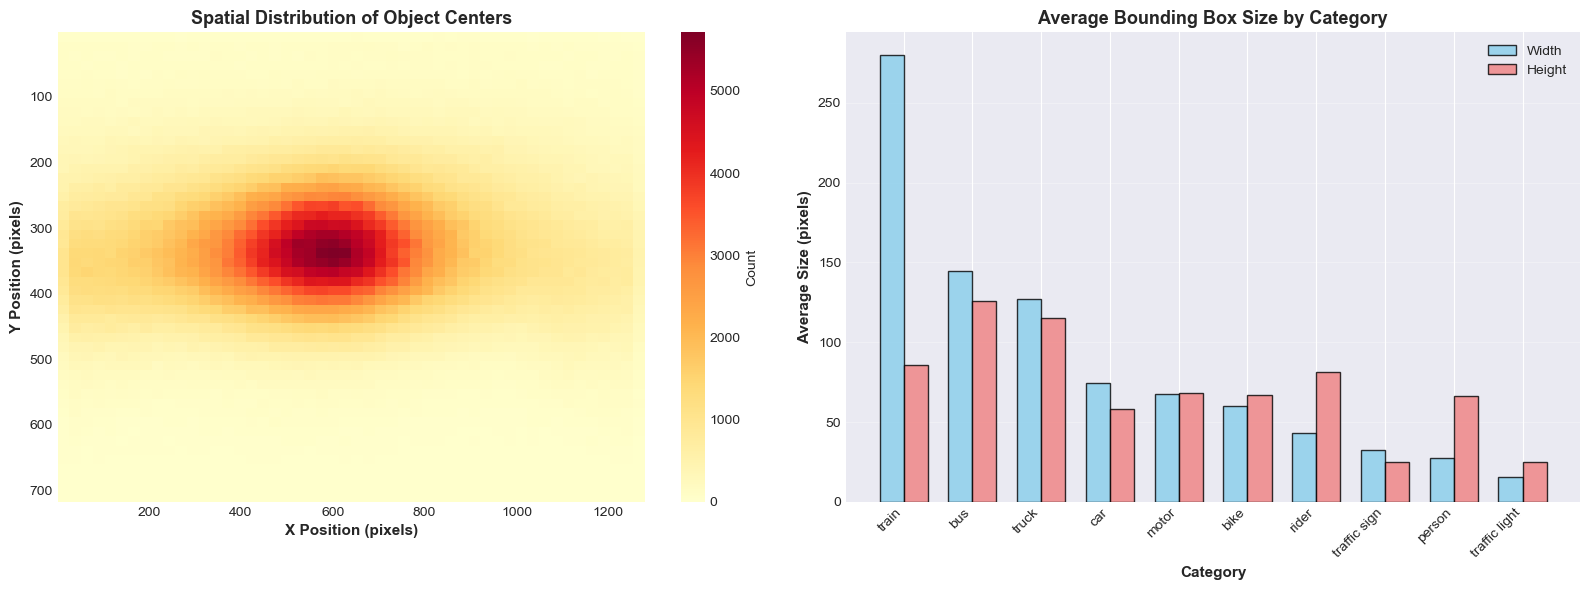

In [42]:
# Spatial distribution of objects (heatmap)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 2D histogram of box centers
h = axes[0].hist2d(detection_boxes_df['center_x'], detection_boxes_df['center_y'], 
                 bins=50, cmap='YlOrRd', edgecolors='none')
axes[0].set_xlabel('X Position (pixels)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Y Position (pixels)', fontsize=11, fontweight='bold')
axes[0].set_title('Spatial Distribution of Object Centers', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()  # Image coordinates
plt.colorbar(h[3], ax=axes[0], label='Count')

# Average box size by category
avg_size_by_cat = detection_boxes_df.groupby('category')[['width', 'height']].mean()
avg_size_by_cat['area'] = avg_size_by_cat['width'] * avg_size_by_cat['height']
avg_size_by_cat = avg_size_by_cat.sort_values('width', ascending=False)

x_pos = np.arange(len(avg_size_by_cat))
width = 0.35

bars1 = axes[1].bar(x_pos - width/2, avg_size_by_cat['width'], width, 
                     label='Width', color='skyblue', edgecolor='black', alpha=0.8)
bars2 = axes[1].bar(x_pos + width/2, avg_size_by_cat['height'], width, 
                     label='Height', color='lightcoral', edgecolor='black', alpha=0.8)

axes[1].set_xlabel('Category', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Average Size (pixels)', fontsize=11, fontweight='bold')
axes[1].set_title('Average Bounding Box Size by Category', fontsize=13, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(avg_size_by_cat.index, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Objects Per Image

Analyzing the distribution of object counts per image.

In [43]:
# Combine objects per image from all splits
all_objects_per_image = []
for split_data in all_data.values():
    all_objects_per_image.extend(split_data['objects_per_image'])

# Convert to array
objects_per_image = np.array(all_objects_per_image)

# Statistics
print("=" * 60)
print("OBJECTS PER IMAGE STATISTICS")
print("=" * 60)
print(f"\nTotal images analyzed: {len(objects_per_image):,}")
print(f"Total objects: {objects_per_image.sum():,}")
print(f"Average objects per image: {objects_per_image.mean():.2f}")
print(f"Median objects per image: {np.median(objects_per_image):.1f}")
print(f"Min objects per image: {objects_per_image.min()}")
print(f"Max objects per image: {objects_per_image.max()}")
print(f"Std deviation: {objects_per_image.std():.2f}")

# Percentiles
percentiles = [25, 50, 75, 90, 95, 99]
print("\nPercentiles:")
for p in percentiles:
    print(f"  {p}%: {np.percentile(objects_per_image, p):.1f}")

OBJECTS PER IMAGE STATISTICS

Total images analyzed: 100,000
Total objects: 2,777,733
Average objects per image: 27.78
Median objects per image: 26.0
Min objects per image: 4
Max objects per image: 109
Std deviation: 12.88

Percentiles:
  25%: 18.0
  50%: 26.0
  75%: 35.0
  90%: 45.0
  95%: 52.0
  99%: 66.0


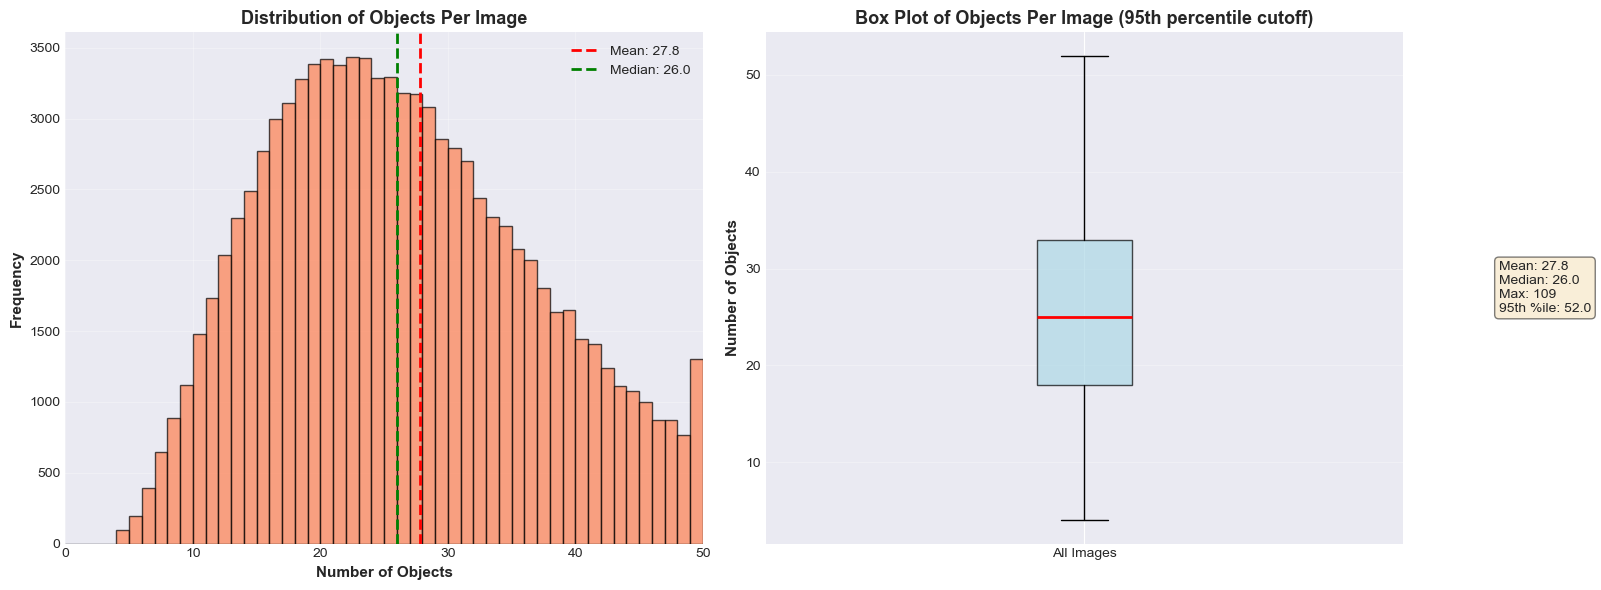

In [44]:
# Visualize objects per image
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
axes[0].hist(objects_per_image, bins=range(0, min(int(objects_per_image.max()) + 1, 51)), 
             color='coral', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Number of Objects', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title('Distribution of Objects Per Image', fontsize=13, fontweight='bold')
axes[0].axvline(objects_per_image.mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {objects_per_image.mean():.1f}")
axes[0].axvline(np.median(objects_per_image), color='green', linestyle='--', linewidth=2, label=f"Median: {np.median(objects_per_image):.1f}")
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_xlim(0, min(50, int(objects_per_image.max())))

# Box plot
box_data = [objects_per_image[objects_per_image <= np.percentile(objects_per_image, 95)]]
bp = axes[1].boxplot(box_data, vert=True, patch_artist=True,
                    medianprops=dict(color='red', linewidth=2),
                    boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1].set_ylabel('Number of Objects', fontsize=11, fontweight='bold')
axes[1].set_title('Box Plot of Objects Per Image (95th percentile cutoff)', fontsize=13, fontweight='bold')
axes[1].set_xticklabels(['All Images'])
axes[1].grid(axis='y', alpha=0.3)

# Add statistics text
stats_text = f"Mean: {objects_per_image.mean():.1f}\nMedian: {np.median(objects_per_image):.1f}\n"
stats_text += f"Max: {int(objects_per_image.max())}\n95th %ile: {np.percentile(objects_per_image, 95):.1f}"
axes[1].text(1.15, 0.5, stats_text, transform=axes[1].transAxes,
            verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

In [45]:
# Find images with most and least objects
# Need to remap to get actual filenames
def get_objects_count_by_split(split):
    lbl_dir = label_paths[split]
    result = []
    for label_file in lbl_dir.glob("*.json"):
        try:
            with open(label_file, 'r') as f:
                data = json.load(f)
            count = 0
            if 'frames' in data and len(data['frames']) > 0:
                count = len(data['frames'][0].get('objects', []))
            result.append((label_file.stem, count))
        except:
            pass
    return result

# Get top and bottom images
train_counts = get_objects_count_by_split('train')
train_counts_sorted = sorted(train_counts, key=lambda x: x[1], reverse=True)

print("=" * 70)
print("IMAGES WITH MOST OBJECTS (Top 10)")
print("=" * 70)
for i, (img_id, count) in enumerate(train_counts_sorted[:10], 1):
    print(f"  {i:2d}. {img_id}: {count} objects")

print("\n" + "=" * 70)
print("IMAGES WITH LEAST OBJECTS (Bottom 10 - excluding 0)")
print("=" * 70)
non_zero = [x for x in train_counts_sorted if x[1] > 0]
for i, (img_id, count) in enumerate(non_zero[-10:][::-1], 1):
    print(f"  {i:2d}. {img_id}: {count} objects")

IMAGES WITH MOST OBJECTS (Top 10)
   1. 7a9d6ddb-f6db12be: 107 objects
   2. 3bd6b5a8-8c096efb: 106 objects
   3. 9936664c-8f82bb48: 104 objects
   4. 9f813b6a-18e666e2: 101 objects
   5. 5488ff78-d6d75d2c: 100 objects
   6. a3d81283-5b9afb34: 100 objects
   7. a554178d-522999d5: 100 objects
   8. 76268f3b-2dcfaea0: 98 objects
   9. 917b9dd0-73b84c3a: 97 objects
  10. 1c752ea4-99dfacb8: 96 objects

IMAGES WITH LEAST OBJECTS (Bottom 10 - excluding 0)
   1. fdd39703-14b52329: 4 objects
   2. ae66fe02-0f4dfea6: 4 objects
   3. a6d12e21-fc3e2cb4: 4 objects
   4. 9f46106d-fbb8a920: 4 objects
   5. 9dec6d97-ab2c968e: 4 objects
   6. 99b37fef-370c8791: 4 objects
   7. 91c323d2-d95edd81: 4 objects
   8. 91644fc9-c66430a9: 4 objects
   9. 904f7a4f-359e0e6c: 4 objects
  10. 9041da01-4d302ef7: 4 objects


## 8. Traffic Light Color Distribution

Analyzing the distribution of traffic light colors.

In [46]:
# Combine traffic light colors from all splits
all_tl_colors = []
for split_data in all_data.values():
    all_tl_colors.extend(split_data['traffic_light_colors'])

# Count colors
tl_color_counts = Counter(all_tl_colors)

print("=" * 60)
print("TRAFFIC LIGHT COLOR DISTRIBUTION")
print("=" * 60)
print(f"\nTotal traffic lights: {len(all_tl_colors):,}")

for color, count in tl_color_counts.most_common():
    pct = count / len(all_tl_colors) * 100 if len(all_tl_colors) > 0 else 0
    print(f"  {color:10s}: {count:>8,} ({pct:>5.2f}%)")

TRAFFIC LIGHT COLOR DISTRIBUTION

Total traffic lights: 266,032
  green     :  113,177 (42.54%)
  none      :   82,017 (30.83%)
  red       :   65,895 (24.77%)
  yellow    :    4,943 ( 1.86%)


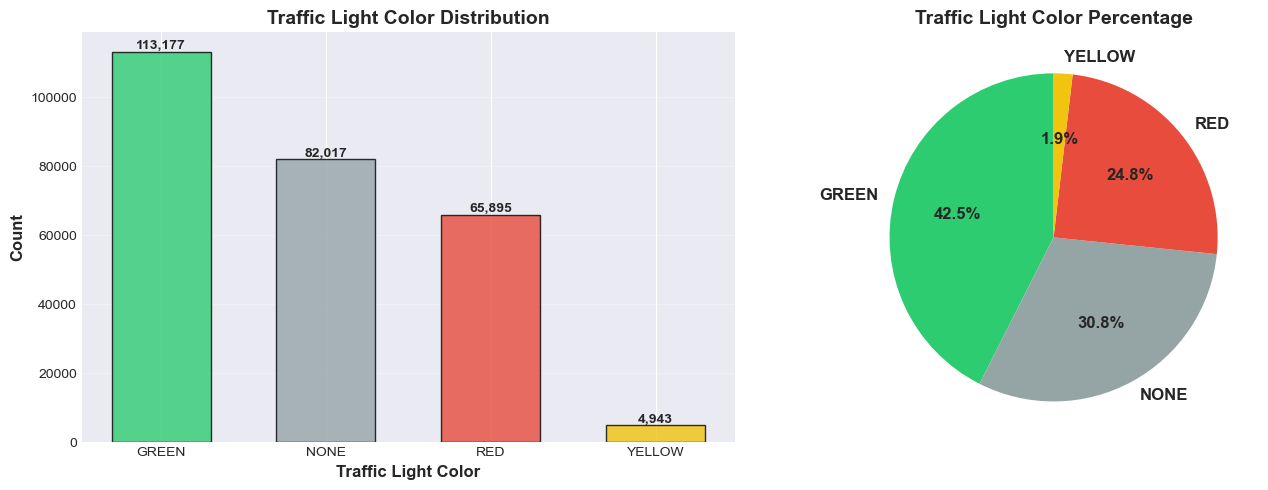

In [47]:
# Visualize traffic light colors
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Color mapping
color_map = {
    'green': '#2ecc71',
    'red': '#e74c3c',
    'yellow': '#f1c40f',
    'none': '#95a5a6'
}

# Bar plot
tl_df = pd.DataFrame(list(tl_color_counts.items()), columns=['Color', 'Count'])
tl_df = tl_df.sort_values('Count', ascending=False)
colors = [color_map.get(c, '#3498db') for c in tl_df['Color']]

bars = axes[0].bar(tl_df['Color'].str.upper(), tl_df['Count'], color=colors, 
                   edgecolor='black', alpha=0.8, width=0.6)
axes[0].set_xlabel('Traffic Light Color', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Traffic Light Color Distribution', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom', fontweight='bold')

# Pie chart
wedges, texts, autotexts = axes[1].pie(tl_df['Count'], 
                                         labels=[c.upper() for c in tl_df['Color']], 
                                         autopct='%1.1f%%', 
                                         colors=colors, 
                                         startangle=90, 
                                         textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Traffic Light Color Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Image Visualization with Annotations

Visualizing sample images with their bounding box annotations.

In [59]:
# Category to color mapping
COLOR_MAP = {
    'car': '#FF0000',
    'truck': '#0000FF',
    'bus': '#00FF00',
    'person': '#FF00FF',
    'rider': '#00FFFF',
    'bike': '#FFFF00',
    'motor': '#FF8800',
    'traffic light': '#888888',
    'traffic sign': '#8800FF',
    'train': '#008888',
    'trailer': '#888800',
    'default': '#000000'
}

def load_label(label_path):
    """Load label JSON file."""
    with open(label_path, 'r') as f:
        return json.load(f)

def draw_annotations(image_path, label_path, max_objects=None):
    """
    Draw bounding boxes on an image.
    
    Args:
        image_path: Path to the image file
        label_path: Path to the label JSON file
        max_objects: Maximum number of objects to draw (None for all)
    
    Returns:
        PIL Image with drawn annotations
    """
    # Load image
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)
    
    # Load labels
    label_data = load_label(label_path)
    
    # Get objects
    objects = []
    if 'frames' in label_data and len(label_data['frames']) > 0:
        objects = label_data['frames'][0].get('objects', [])
    
    if max_objects:
        objects = objects[:max_objects]
    
    # Draw each object
    for obj in objects:
        if 'box2d' in obj:
            category = obj.get('category', 'unknown')
            box = obj['box2d']
            
            x1, y1, x2, y2 = box['x1'], box['y1'], box['x2'], box['y2']
            color = COLOR_MAP.get(category, COLOR_MAP['default'])
            
            # Draw bounding box
            draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
            
            # Draw label
            draw.text((x1, y1 - 15), category, fill=color)
    
    return img

def visualize_grid(image_dir, label_dir, num_samples=6, seed=42):
    """
    Create a grid visualization of sample images with annotations.
    """
    # np.random.seed(seed)
    
    # Get random sample of label files
    label_files = list(label_dir.glob("*.json"))
    samples = np.random.choice(label_files, min(num_samples, len(label_files)), replace=False)
    
    # Calculate grid size
    cols = min(3, num_samples)
    rows = (num_samples + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
    if num_samples == 1:
        axes = [axes]
    elif rows == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for i, label_file in enumerate(samples):
        img_id = label_file.stem
        img_path = image_dir / f"{img_id}.jpg"
        
        if img_path.exists():
            annotated_img = draw_annotations(img_path, label_file)
            axes[i].imshow(annotated_img)
            axes[i].set_title(f"{img_id}", fontsize=10, fontweight='bold')
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, f"Image not found\n{img_id}", 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    
    # Hide extra subplots
    for i in range(len(samples), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Visualization functions defined.")

Visualization functions defined.


Loading sample training images with annotations...


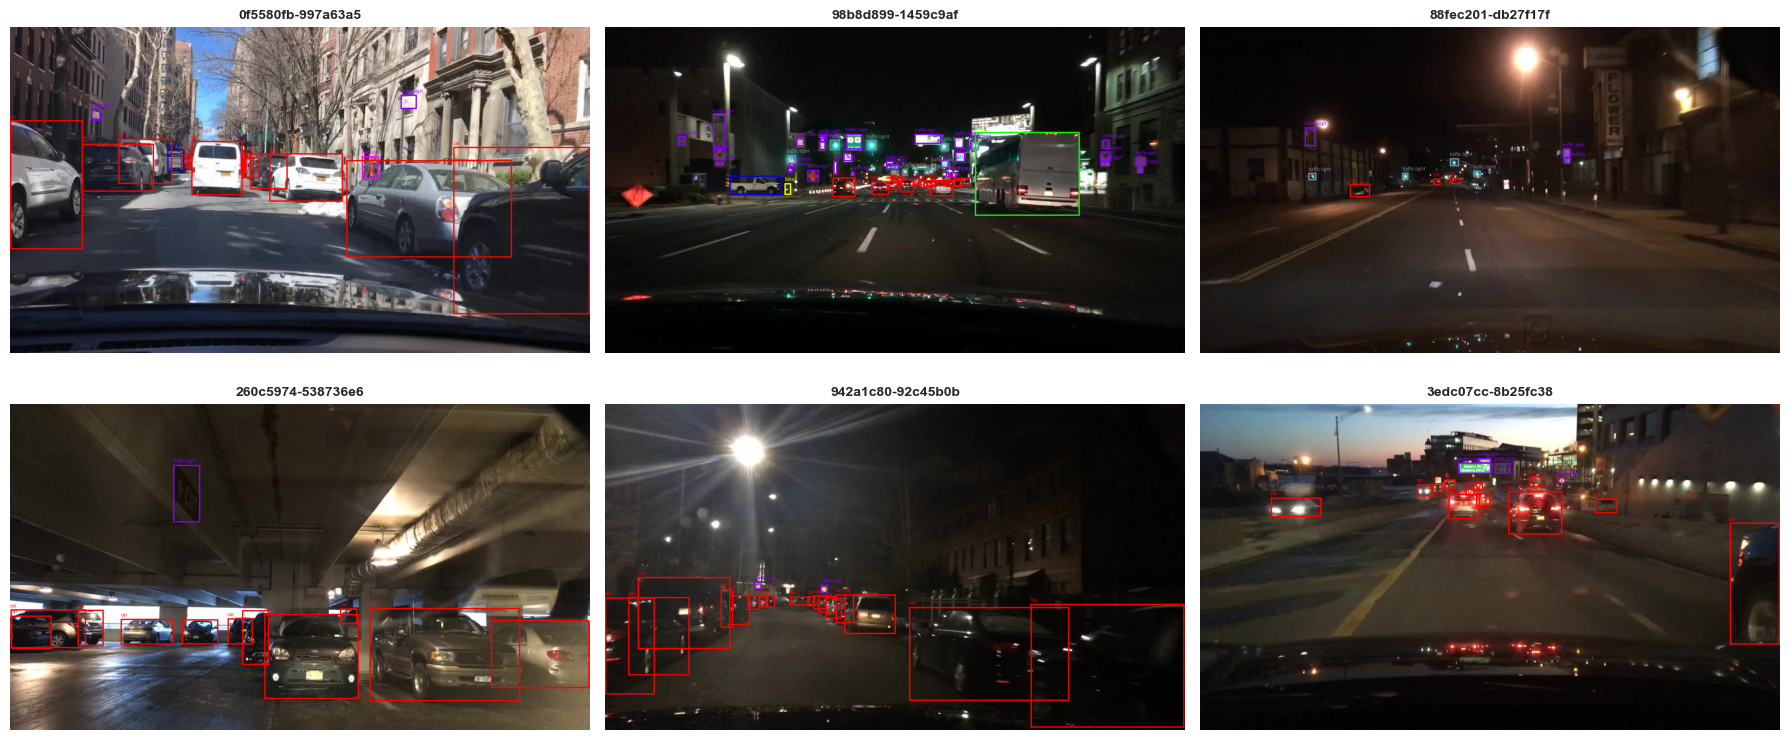

In [66]:
# Visualize sample training images
print("Loading sample training images with annotations...")
visualize_grid(image_paths['train'], label_paths['train'], num_samples=6, seed=1)

Loading sample validation images with annotations...


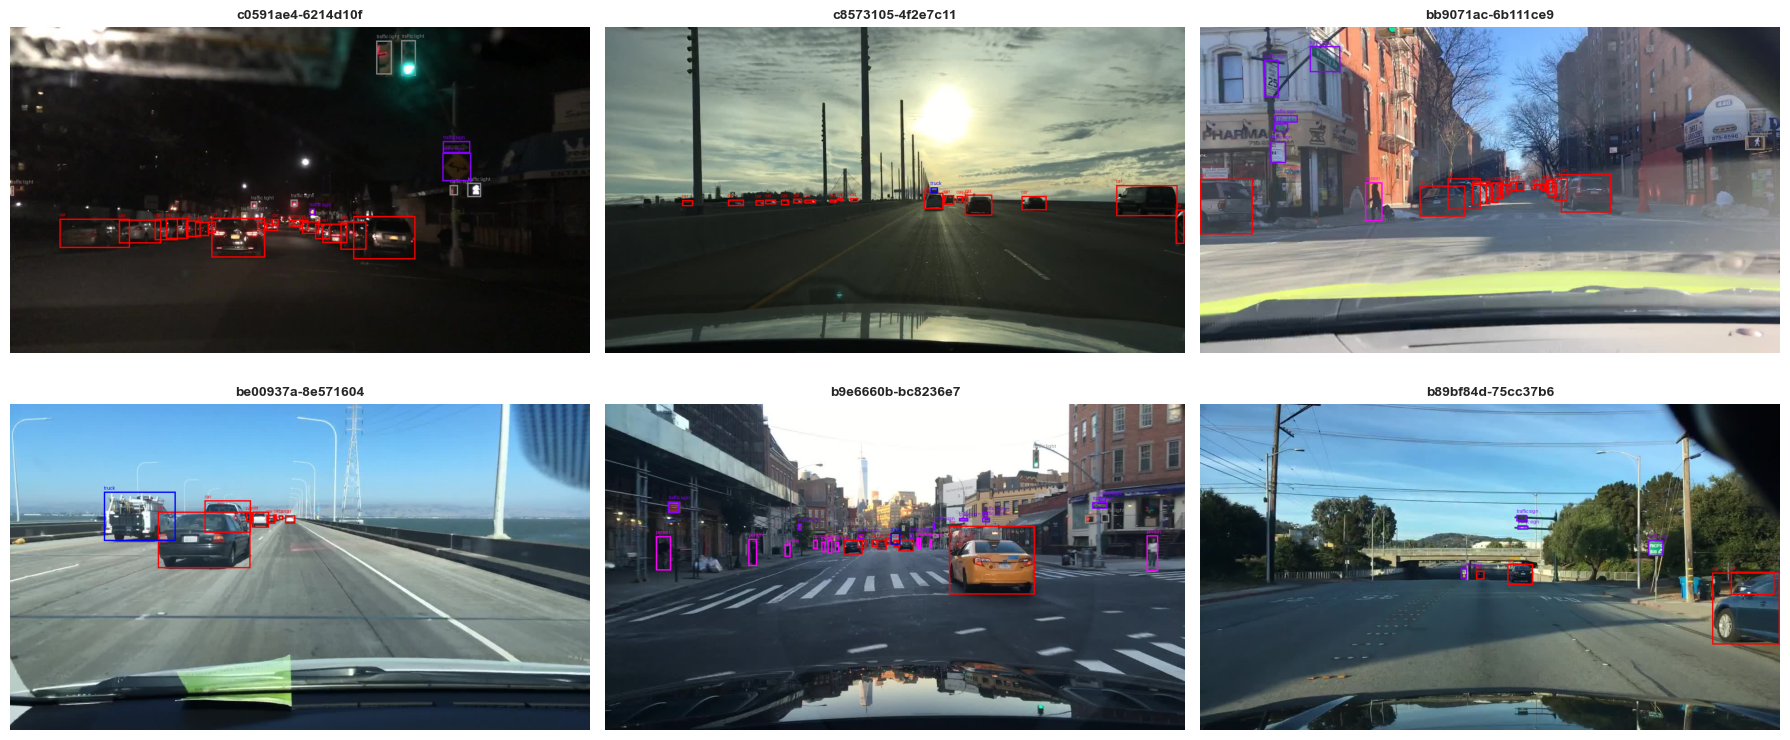

In [71]:
# Visualize sample validation images
print("Loading sample validation images with annotations...")
visualize_grid(image_paths['val'], label_paths['val'], num_samples=6, seed=123)


Examples of 'car':


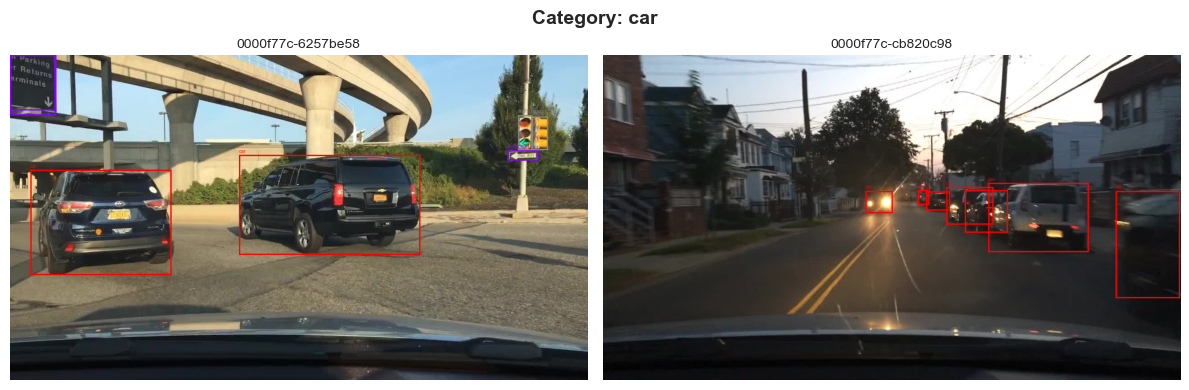


Examples of 'person':


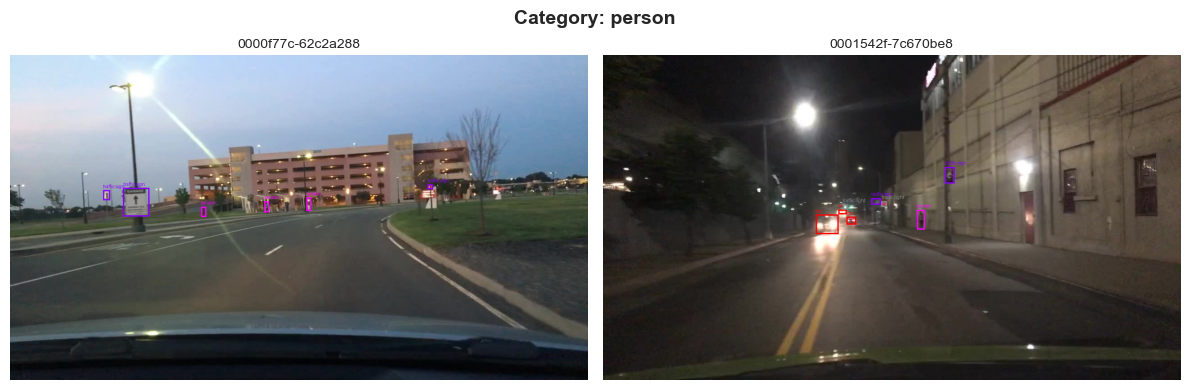


Examples of 'traffic light':


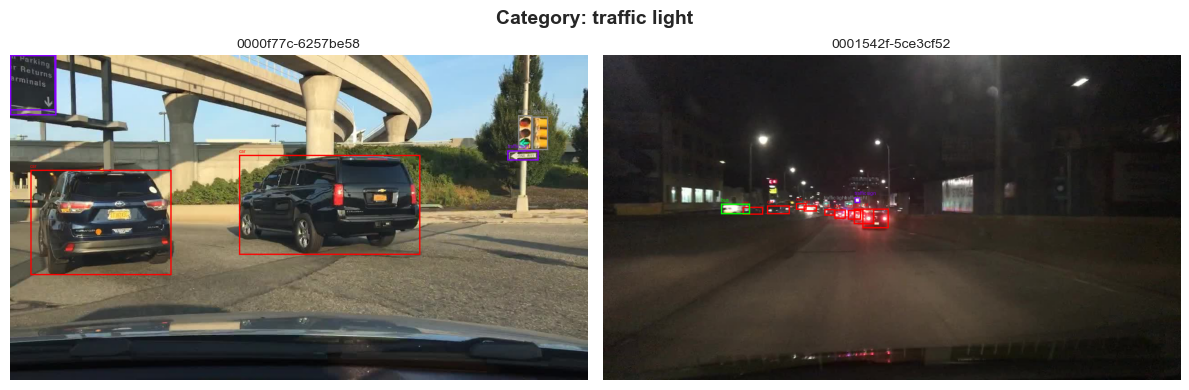


Examples of 'truck':


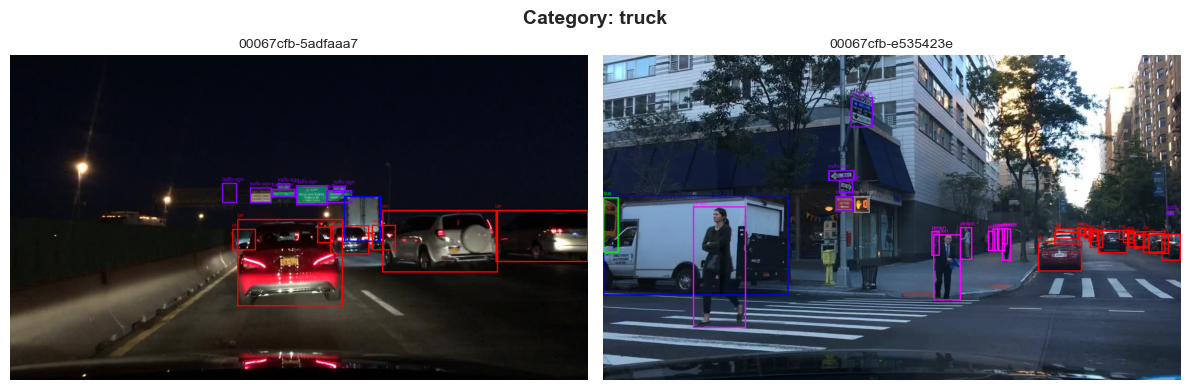

In [74]:
# Visualize by category - show examples of each detection category
def find_images_by_category(split, category, max_results=3):
    """Find images containing a specific category."""
    results = []
    lbl_dir = label_paths[split]
    
    for label_file in lbl_dir.glob("*.json"):
        if len(results) >= max_results:
            break
        try:
            with open(label_file, 'r') as f:
                data = json.load(f)
            
            if 'frames' in data and len(data['frames']) > 0:
                for obj in data['frames'][0].get('objects', []):
                    if obj.get('category') == category:
                        results.append(label_file)
                        break
        except:
            pass
    
    return results

# Show examples for each detection category
for category in ['car', 'person', 'traffic light', 'truck']:
    print(f"\nExamples of '{category}':")
    examples = find_images_by_category('train', category, max_results=2)
    
    if examples:
        fig, axes = plt.subplots(1, len(examples), figsize=(12, 4))
        if len(examples) == 1:
            axes = [axes]
        
        for i, label_file in enumerate(examples):
            img_id = label_file.stem
            img_path = image_paths['train'] / f"{img_id}.jpg"
            
            if img_path.exists():
                annotated_img = draw_annotations(img_path, label_file)
                axes[i].imshow(annotated_img)
                axes[i].set_title(f"{img_id}", fontsize=10)
                axes[i].axis('off')
        
        plt.suptitle(f"Category: {category}", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print(f"  No examples found.")

## 10. Statistics Summary

Creating a comprehensive summary table of all key statistics.

In [75]:
# Create comprehensive summary DataFrame
summary_data = []

# Dataset overview
summary_data.append({'Metric': 'Total Images', 'Value': f"{overview_df[overview_df['Split'] == 'TOTAL']['Images'].values[0]:,}"})
summary_data.append({'Metric': 'Total Training Images', 'Value': f"{overview_df[overview_df['Split'] == 'train']['Images'].values[0]:,}"})
summary_data.append({'Metric': 'Total Validation Images', 'Value': f"{overview_df[overview_df['Split'] == 'val']['Images'].values[0]:,}"})
summary_data.append({'Metric': 'Total Test Images', 'Value': f"{overview_df[overview_df['Split'] == 'test']['Images'].values[0]:,}"})

# Objects
summary_data.append({'Metric': 'Total Annotated Objects', 'Value': f"{category_df['Count'].sum():,}"})
summary_data.append({'Metric': 'Unique Categories', 'Value': f"{len(category_df)}"})
summary_data.append({'Metric': 'Avg Objects Per Image', 'Value': f"{objects_per_image.mean():.2f}"})
summary_data.append({'Metric': 'Median Objects Per Image', 'Value': f"{np.median(objects_per_image):.1f}"})

# Most common categories
top_cat = category_df.iloc[0]
summary_data.append({'Metric': 'Most Common Category', 'Value': f"{top_cat['Category']} ({top_cat['Percentage']}%)"})
summary_data.append({'Metric': 'Detection Categories', 'Value': f"{len(detection_df)}"})

# Attributes
summary_data.append({'Metric': 'Most Common Weather', 'Value': weather_counts.most_common(1)[0][0] if weather_counts else 'N/A'})
summary_data.append({'Metric': 'Most Common Scene', 'Value': scene_counts.most_common(1)[0][0] if scene_counts else 'N/A'})
summary_data.append({'Metric': 'Most Common Time', 'Value': timeofday_counts.most_common(1)[0][0] if timeofday_counts else 'N/A'})

# Bounding boxes
summary_data.append({'Metric': 'Avg Box Width', 'Value': f"{detection_boxes_df['width'].mean():.1f} px"})
summary_data.append({'Metric': 'Avg Box Height', 'Value': f"{detection_boxes_df['height'].mean():.1f} px"})
summary_data.append({'Metric': 'Avg Box Area', 'Value': f"{detection_boxes_df['area'].mean():.0f} px²"})

# Traffic lights
summary_data.append({'Metric': 'Total Traffic Lights', 'Value': f"{len(all_tl_colors):,}"})
if tl_color_counts:
    most_common_tl = tl_color_counts.most_common(1)[0]
    summary_data.append({'Metric': 'Most Common TL Color', 'Value': f"{most_common_tl[0]} ({most_common_tl[1]/len(all_tl_colors)*100:.1f}%)"})

# Occlusion/Truncation
all_occluded = []
all_truncated = []
for split_data in all_data.values():
    all_occluded.extend(split_data['occluded'])
    all_truncated.extend(split_data['truncated'])

summary_data.append({'Metric': 'Occluded Objects', 'Value': f"{sum(all_occluded)} ({sum(all_occluded)/len(all_occluded)*100:.1f}%)" if all_occluded else 'N/A'})
summary_data.append({'Metric': 'Truncated Objects', 'Value': f"{sum(all_truncated)} ({sum(all_truncated)/len(all_truncated)*100:.1f}%)" if all_truncated else 'N/A'})

# Create DataFrame
summary_df = pd.DataFrame(summary_data)

print("=" * 60)
print("BDD100K DATASET - COMPREHENSIVE SUMMARY")
print("=" * 60)
summary_df

BDD100K DATASET - COMPREHENSIVE SUMMARY


Metric           Value
0               Total Images         100,000
1      Total Training Images          70,000
2    Total Validation Images          10,000
3          Total Test Images          20,000
4    Total Annotated Objects       2,777,733
5          Unique Categories              21
6      Avg Objects Per Image           27.78
7   Median Objects Per Image            26.0
8       Most Common Category    car (36.79%)
9       Detection Categories              10
10       Most Common Weather           clear
11         Most Common Scene     city street
12          Most Common Time         daytime
13             Avg Box Width         56.6 px
14            Avg Box Height         49.8 px
15              Avg Box Area        6754 px²
16      Total Traffic Lights         266,032
17      Most Common TL Color   green (42.5%)
18          Occluded Objects  871213 (31.4%)
19         Truncated Objects   127481 (4.6%)

In [76]:
# Export summary to CSV
export_path = BASE_DIR / "dataset_summary.csv"
summary_df.to_csv(export_path, index=False)
print(f"\nSummary exported to: {export_path}")

# Also export category distribution
category_export_path = BASE_DIR / "category_distribution.csv"
category_df.to_csv(category_export_path, index=False)
print(f"Category distribution exported to: {category_export_path}")


Summary exported to: c:\My Projects\road-object-detection\dataset_summary.csv
Category distribution exported to: c:\My Projects\road-object-detection\category_distribution.csv


## 11. Insights & Recommendations for YOLO11 Training

In [77]:
print("=" * 80)
print("KEY INSIGHTS & RECOMMENDATIONS FOR YOLO11 TRAINING")
print("=" * 80)

print("\n" + "-" * 80)
print("1. DATASET COMPOSITION")
print("-" * 80)
print(f"   - Total images: {overview_df[overview_df['Split'] == 'TOTAL']['Images'].values[0]:,}")
print(f"   - Train/Val/Test split: 70% / 10% / 20%")
print(f"   - Average objects per image: {objects_per_image.mean():.1f}")
print(f"   - Total annotated objects: {category_df['Count'].sum():,}")

print("\n" + "-" * 80)
print("2. CLASS IMBALANCE ANALYSIS")
print("-" * 80)
print("   Top 5 detection categories:")
for i, row in detection_df.head(5).iterrows():
    print(f"   - {row['Category']:15s}: {row['Count']:>10,} ({row['Percentage']:>5.2f}%)")

rare_classes = detection_df[detection_df['Count'] < detection_df['Count'].max() * 0.01]
if len(rare_classes) > 0:
    print("\n   Rare classes (<1% of most common):")
    for i, row in rare_classes.iterrows():
        print(f"   - {row['Category']:15s}: {row['Count']:>10,} ({row['Percentage']:>5.2f}%)")

print("\n   Recommendation: Use class weights or focal loss to handle imbalance.")

print("\n" + "-" * 80)
print("3. ENVIRONMENTAL DIVERSITY")
print("-" * 80)
print("   Weather conditions:")
for weather, count in weather_counts.most_common():
    pct = count / sum(weather_counts.values()) * 100
    print(f"   - {weather:15s}: {pct:>5.1f}%")

print("\n   Scene types:")
for scene, count in scene_counts.most_common():
    pct = count / sum(scene_counts.values()) * 100
    print(f"   - {scene:15s}: {pct:>5.1f}%")

print("\n   Time of day:")
for tod, count in timeofday_counts.most_common():
    pct = count / sum(timeofday_counts.values()) * 100
    print(f"   - {tod:15s}: {pct:>5.1f}%")

print("\n   Recommendation: Dataset has good diversity. Consider oversampling")
print("   rare conditions (foggy, snowy) if model performance on them is poor.")

print("\n" + "-" * 80)
print("4. OBJECT SIZE DISTRIBUTION")
print("-" * 80)
print(f"   - Average box width: {detection_boxes_df['width'].mean():.1f} pixels")
print(f"   - Average box height: {detection_boxes_df['height'].mean():.1f} pixels")
print(f"   - Average aspect ratio: {detection_boxes_df['aspect_ratio'].median():.2f}")
print(f"   - Small objects (<32px): {(detection_boxes_df['width'] < 32).sum() / len(detection_boxes_df) * 100:.1f}%")
print(f"   - Medium objects (32-96px): {((detection_boxes_df['width'] >= 32) & (detection_boxes_df['width'] < 96)).sum() / len(detection_boxes_df) * 100:.1f}%")
print(f"   - Large objects (>96px): {(detection_boxes_df['width'] >= 96).sum() / len(detection_boxes_df) * 100:.1f}%")

print("\n   Recommendation: Consider using multi-scale training and feature pyramid")
print("   networks (FPN) to handle varying object sizes effectively.")

print("\n" + "-" * 80)
print("5. OBJECT CHALLENGES")
print("-" * 80)
if all_occluded:
    occluded_rate = sum(all_occluded) / len(all_occluded) * 100
    print(f"   - Occluded objects: {occluded_rate:.1f}%")
if all_truncated:
    truncated_rate = sum(all_truncated) / len(all_truncated) * 100
    print(f"   - Truncated objects: {truncated_rate:.1f}%")

print("\n   Recommendation: Use data augmentation (random crop, occlusion simulation)")
print("   to improve model robustness.")

print("\n" + "-" * 80)
print("6. YOLO11 TRAINING RECOMMENDATIONS")
print("-" * 80)
print("   Hyperparameters to consider:")
print("   - Image size: 640x640 (standard) or 1280x720 (native resolution)")
print("   - Batch size: 16-32 (adjust based on GPU memory)")
print("   - Epochs: 100-300 (use early stopping)")
print("   - Learning rate: 0.001 (default) with cosine annealing")
print("   - Augmentation: mosaic, mixup, flip, HSV adjustment")
print("   - Class weights: inverse frequency weighting for rare classes")

print("\n   Recommended training strategy:")
print("   1. Start with pre-trained YOLO11 weights (COCO)")
print("   2. Freeze backbone for first 10 epochs")
print("   3. Use Mosaic augmentation for small object detection")
print("   4. Implement class weights for rare categories")
print("   5. Monitor mAP@0.5 and mAP@0.5:0.95 separately")
print("   6. Validate per-class AP to identify weak categories")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE!")
print("=" * 80)

KEY INSIGHTS & RECOMMENDATIONS FOR YOLO11 TRAINING

--------------------------------------------------------------------------------
1. DATASET COMPOSITION
--------------------------------------------------------------------------------
   - Total images: 100,000
   - Train/Val/Test split: 70% / 10% / 20%
   - Average objects per image: 27.8
   - Total annotated objects: 2,777,733

--------------------------------------------------------------------------------
2. CLASS IMBALANCE ANALYSIS
--------------------------------------------------------------------------------
   Top 5 detection categories:
   - car            :  1,021,811 (36.79%)
   - traffic sign   :    343,882 (12.38%)
   - traffic light  :    266,032 ( 9.58%)
   - person         :    129,350 ( 4.66%)
   - truck          :     42,963 ( 1.55%)

   Rare classes (<1% of most common):
   - rider          :      6,465 ( 0.23%)
   - motor          :      4,295 ( 0.15%)
   - train          :        179 ( 0.01%)

   Recommendation:

---

## Summary

This notebook provides a comprehensive exploration of the BDD100K dataset including:

1. **Dataset Overview**: 100K images (70K train, 10K val, 20K test)
2. **Class Distribution**: Analysis of object categories and identification of class imbalance
3. **Attribute Analysis**: Weather, scene, and time-of-day distributions
4. **Bounding Box Analysis**: Size, position, and aspect ratio statistics
5. **Objects Per Image**: Distribution and density analysis
6. **Traffic Light Colors**: Specific breakdown for traffic light category
7. **Visualizations**: Sample images with annotations and statistical plots
8. **Recommendations**: YOLO11 training tips based on data analysis

### Files Generated:
- `dataset_summary.csv`: Comprehensive dataset statistics
- `category_distribution.csv`: Object category counts and percentages

### Next Steps:
1. Convert labels to YOLO format (if needed)
2. Set up YOLO11 training configuration
3. Create data.yaml for YOLO11
4. Implement data augmentation pipeline
5. Train and validate the model